## Here we demostrate step-by-step how to tune the Doc2Vec version of the Gradient Boosting Tree using `sklearn`

In [1]:
'''coding envrionment Python 3.5'''
## common packages
import os, sys, importlib
# from __future__ import division # if you want to use python 2.x
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## machine learning packages
from sklearn.ensemble import GradientBoostingClassifier #GBC algorithm
from sklearn import linear_model, cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

## in-house library
import Ensemble_library as ES
from Ensemble_tuned_parameters import *
ES = importlib.reload(ES)

### Read the data and further preprocessing...

In [2]:
## read the data
vectors = pd.read_csv(doc2Vec_file,index_col=0)
print("import size:",vectors.shape)

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered = vectors[vectors['Label']!=2].dropna()
else:
    vectors_filtered = vectors.dropna()

## add 2 more columns of the sign of the change
vectors_filtered['ROE_excess_change_sign'] = vectors_filtered['ROE_excess_change']>0
vectors_filtered['ROE_change_sign'] = vectors_filtered['ROE_change']>0

## check if there is any missing data
assert vectors_filtered.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print("Total DF shape: ", vectors_filtered.shape)
m = len(vectors_filtered)

colnames = vectors_filtered.columns.values
#colnames

import size: (28532, 331)
Total DF shape:  (21344, 333)


### Specify the x and y variables, split data into train, validation, and test

In [3]:
## we augment the bm model by 300 features
predictors = np.append(colnames[1:301], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled = vectors_filtered.iloc[np.random.permutation(len(vectors_filtered))].reset_index(drop=True)


test_data = vectors_filtered_shuffled.iloc[:int(m*test_portion)]
train_valid_data = vectors_filtered_shuffled.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data)+ len(train_valid_data) == m 

In [4]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
pos_ratio = (vectors_filtered_shuffled[y]>0).sum()/len(vectors_filtered_shuffled)
print("The positive ratio is {:.4f}".format(pos_ratio))

The positive ratio is 0.4943


### Let's train the benchmark models

In [5]:
logistic_bm = linear_model.LogisticRegression(penalty='l2', C = 0.01) ## C is tuned.
logistic_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
gbt_bm = GradientBoostingClassifier(**GBT_bm_params)
gbt_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

GradientBoostingClassifier(init=None, learning_rate=0.026674999999999997,
              loss='deviance', max_depth=5, max_features=9,
              max_leaf_nodes=None, min_samples_leaf=30,
              min_samples_split=1000, min_weight_fraction_leaf=0.0,
              n_estimators=1200, presort='auto', random_state=10,
              subsample=0.85, verbose=0, warm_start=False)

# GBT Tuning below...

In [7]:
learning_rate = 0.5335

## this grid search pick n_estimators
min_samples_split = 0.01*len(vectors_filtered) ## make it 1% of the data
param_test1 = {'n_estimators': list(range(20,101,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
    min_samples_split=min_samples_split,min_samples_leaf=50,max_depth=8, 
    max_features='sqrt',subsample=0.8,random_state=10),
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set min_samples_split={}, and tune n_estimators".format(min_samples_split))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Here we set min_samples_split=213.44, and tune n_estimators


([mean: 0.68483, std: 0.01194, params: {'n_estimators': 20},
  mean: 0.68820, std: 0.01260, params: {'n_estimators': 30},
  mean: 0.68358, std: 0.01241, params: {'n_estimators': 40},
  mean: 0.68176, std: 0.01071, params: {'n_estimators': 50},
  mean: 0.68125, std: 0.01040, params: {'n_estimators': 60},
  mean: 0.68108, std: 0.01298, params: {'n_estimators': 70},
  mean: 0.68228, std: 0.01195, params: {'n_estimators': 80},
  mean: 0.68539, std: 0.01111, params: {'n_estimators': 90},
  mean: 0.68629, std: 0.01058, params: {'n_estimators': 100}],
 {'n_estimators': 30},
 0.68820453838849693)

In [8]:
## this grid search pick max_depth and min_samples_split
n_estimators = gsearch1.best_params_['n_estimators'] ## from previous grid
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split': list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,\
    n_estimators = n_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set n_estimators={}, and tune max_depth and min_samples_split".format(n_estimators))

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Here we set n_estimators=30, and tune max_depth and min_samples_split


([mean: 0.70250, std: 0.01319, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.70058, std: 0.00960, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.70792, std: 0.00568, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.71000, std: 0.01048, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.70960, std: 0.00586, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.68690, std: 0.00405, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.69245, std: 0.00840, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.70594, std: 0.00527, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.70011, std: 0.00998, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.70876, std: 0.00904, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.68356, std: 0.00862, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.68651, std: 0.00748, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [9]:
## this grid search pick min_samples_split and min_samples_leaf

max_depth = gsearch2.best_params_['max_depth']

param_test3 = {'min_samples_split':list(range(1000,2100,200)), 'min_samples_leaf': list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate= learning_rate,\
        n_estimators=n_estimators, max_depth= max_depth,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set max_depth={}, and tune min_samples_split and min_samples_leaf".format(max_depth))

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


Here we set max_depth=5, and tune min_samples_split and min_samples_leaf


([mean: 0.70946, std: 0.00834, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.70685, std: 0.00756, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.71304, std: 0.00714, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.71676, std: 0.00594, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.71122, std: 0.00668, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.71139, std: 0.00267, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.71330, std: 0.00848, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.71143, std: 0.00476, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.71489, std: 0.01178, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.71293, std: 0.00692, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.71410, std: 0.00424, params: {'min_samples_leaf': 40, 'min_samples_spl

In [10]:
## this grid search pick max_features
min_samples_leaf = gsearch3.best_params_['min_samples_leaf']
min_samples_split = gsearch3.best_params_['min_samples_split']

param_test4 = {'max_features': list(range(7,30,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, subsample=0.8, random_state=10),
        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set min_samples_leaf={} and min_samples_split={}, and tune max_features"
      .format(min_samples_leaf,min_samples_split))

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Here we set min_samples_leaf=50 and min_samples_split=1600, and tune max_features


([mean: 0.67225, std: 0.01910, params: {'max_features': 7},
  mean: 0.68311, std: 0.00870, params: {'max_features': 9},
  mean: 0.69159, std: 0.00921, params: {'max_features': 11},
  mean: 0.69277, std: 0.01840, params: {'max_features': 13},
  mean: 0.70955, std: 0.01290, params: {'max_features': 15},
  mean: 0.71762, std: 0.00807, params: {'max_features': 17},
  mean: 0.71599, std: 0.01145, params: {'max_features': 19},
  mean: 0.71692, std: 0.00649, params: {'max_features': 21},
  mean: 0.72256, std: 0.00399, params: {'max_features': 23},
  mean: 0.72245, std: 0.00905, params: {'max_features': 25},
  mean: 0.72731, std: 0.00417, params: {'max_features': 27},
  mean: 0.72563, std: 0.00723, params: {'max_features': 29}],
 {'max_features': 27},
 0.7273119462710439)

In [11]:
## this grid search pick subsample

max_features = gsearch4.best_params_['max_features']

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 =  GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, max_features = max_features, random_state=10),
        param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set max_features={}, and tune subsample".format(max_features))

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Here we set max_features=27, and tune subsample


([mean: 0.71344, std: 0.00328, params: {'subsample': 0.6},
  mean: 0.72379, std: 0.00227, params: {'subsample': 0.7},
  mean: 0.72323, std: 0.00910, params: {'subsample': 0.75},
  mean: 0.72731, std: 0.00417, params: {'subsample': 0.8},
  mean: 0.72665, std: 0.00668, params: {'subsample': 0.85},
  mean: 0.73058, std: 0.00626, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.73057699186337188)

In [12]:
subsample = gsearch5.best_params_['subsample']

In [13]:
print('learning_rate =',learning_rate, ', n_estimators =', n_estimators)

learning_rate = 0.5335 , n_estimators = 30



Model Report
Accuracy : 0.7609
AUC Score (Train): 0.844824
CV Score : Mean - 0.7471401 | Std - 0.004856275 | Min - 0.7406619 | Max - 0.7552575


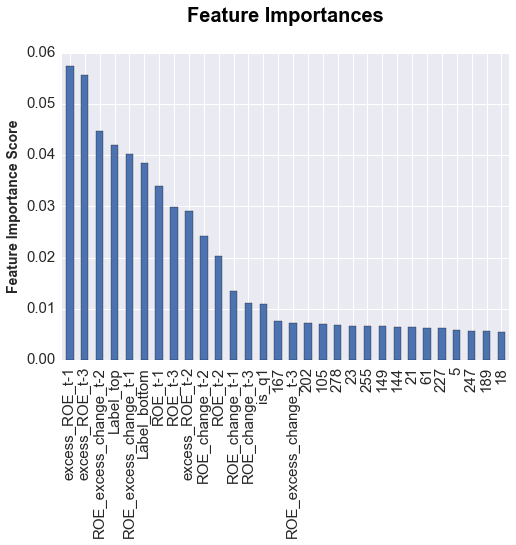

In [15]:
# Lets decrease the learning rate to half with twice the number of trees
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=learning_rate/2, n_estimators=n_estimators*2,
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, subsample=subsample, 
            random_state=10, max_features=max_features)
ES.modelfit(gbm_tuned_1, train_valid_data, predictors, y)



Model Report
Accuracy : 0.7752
AUC Score (Train): 0.863500
CV Score : Mean - 0.7622892 | Std - 0.00535904 | Min - 0.7542059 | Max - 0.7690788


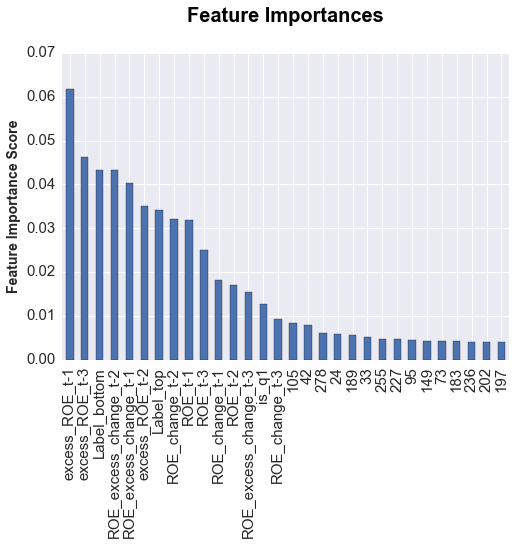

In [16]:
# Now lets reduce to one-tenth of the original value
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=learning_rate/10, n_estimators=n_estimators*10,
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, subsample=subsample, 
            random_state=10, max_features=max_features)
ES.modelfit(gbm_tuned_2, train_valid_data, predictors, y)


Model Report
Accuracy : 0.7762
AUC Score (Train): 0.864740
CV Score : Mean - 0.7644145 | Std - 0.004732406 | Min - 0.7594622 | Max - 0.7705353


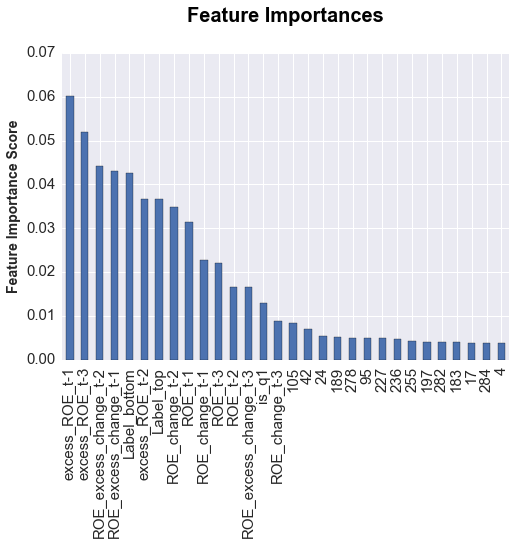

In [17]:
# Now lets reduce to one-twentieth of the original value
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=learning_rate/20, n_estimators=n_estimators*20,
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, subsample=subsample, 
            random_state=10, max_features=max_features)

ES.modelfit(gbm_tuned_3, train_valid_data, predictors, y)

# GBT Tuning Done.

In [18]:
## here we used the pre-trained parameters
## this can be achieved by gbm_tuned_3.getparams()
Doc2Vec_tuned_gbt = GradientBoostingClassifier(**GBT_Doc2Vec_params)
Doc2Vec_tuned_gbt.fit(train_valid_data[predictors], train_valid_data[y])

GradientBoostingClassifier(init=None, learning_rate=0.026674999999999997,
              loss='deviance', max_depth=5, max_features=27,
              max_leaf_nodes=None, min_samples_leaf=50,
              min_samples_split=1600, min_weight_fraction_leaf=0.0,
              n_estimators=600, presort='auto', random_state=10,
              subsample=0.9, verbose=0, warm_start=False)

## Some analysis below:
* We decide to pick the Logistic-regressed benchmark model as our Benchmark, as it generally out-performs the GBT one when the threshold is low.
* Tuned GBT model with 300 features out-performs the benchmark both in-sample and out-of-sample. 

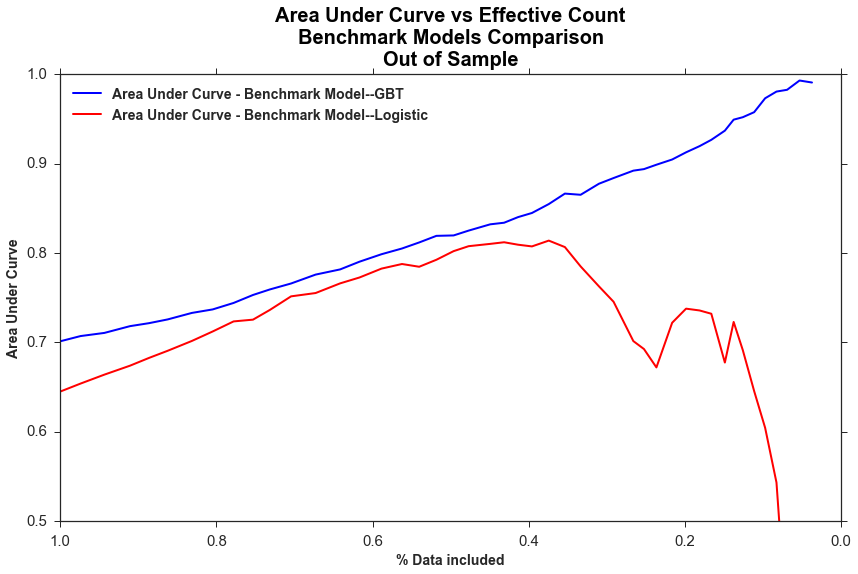

In [19]:
ES.AUCvsCountsPlot(gbt_bm, test_data, predictors_bm, y, 
                       model_name="Benchmark Model--GBT", alg2=logistic_bm, dtest2 = test_data,
                       predictors2=predictors_bm, y2=y, model_name2="Benchmark Model--Logistic",
                       title_second_line = "Benchmark Models Comparison\nOut of Sample")

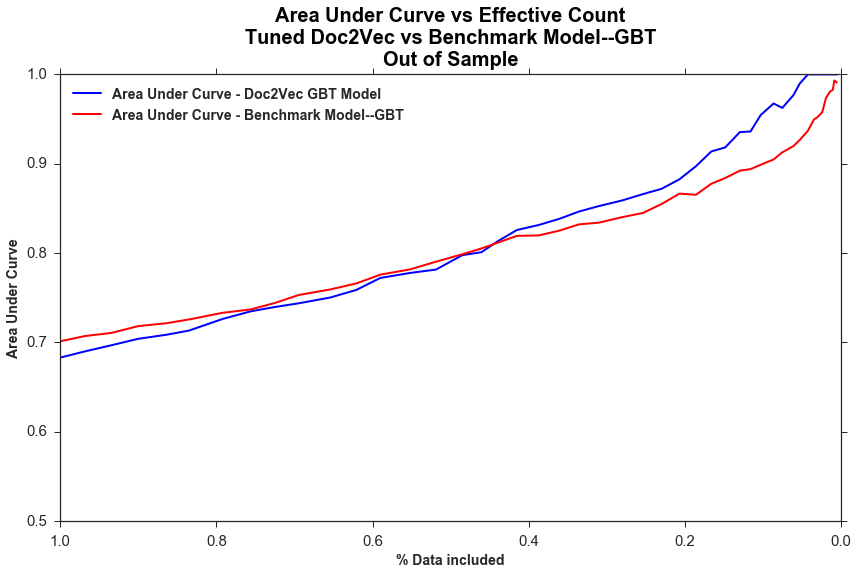

In [20]:
ES.AUCvsCountsPlot(Doc2Vec_tuned_gbt, test_data, predictors, y, 
                       model_name="Doc2Vec GBT Model", alg2=gbt_bm, dtest2 = test_data,
                       predictors2=predictors_bm, y2=y, model_name2="Benchmark Model--GBT", 
                       title_second_line = "Tuned Doc2Vec vs Benchmark Model--GBT\nOut of Sample")

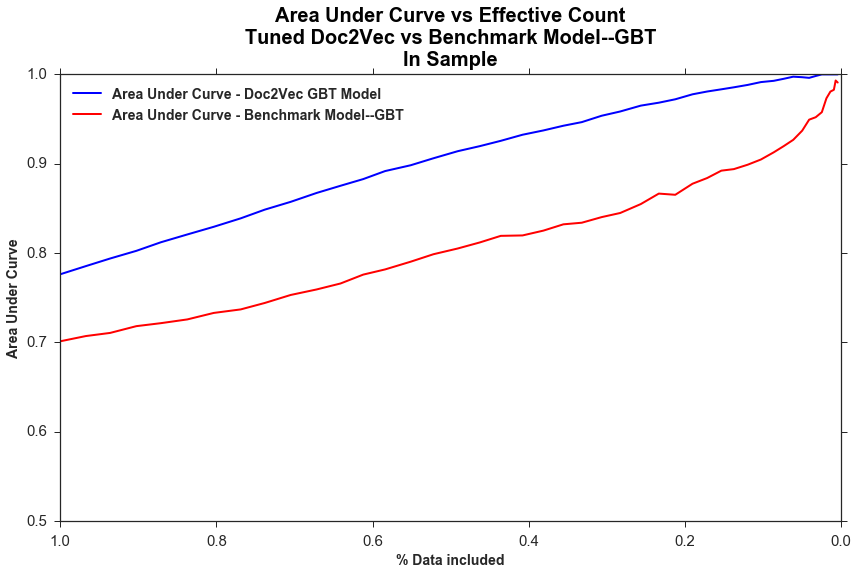

In [22]:
ES.AUCvsCountsPlot(Doc2Vec_tuned_gbt, train_valid_data, predictors, y, 
                       model_name="Doc2Vec GBT Model", alg2=gbt_bm, dtest2 = test_data,
                       predictors2=predictors_bm, y2=y, model_name2="Benchmark Model--GBT",
                       title_second_line = "Tuned Doc2Vec vs Benchmark Model--GBT\nIn Sample")

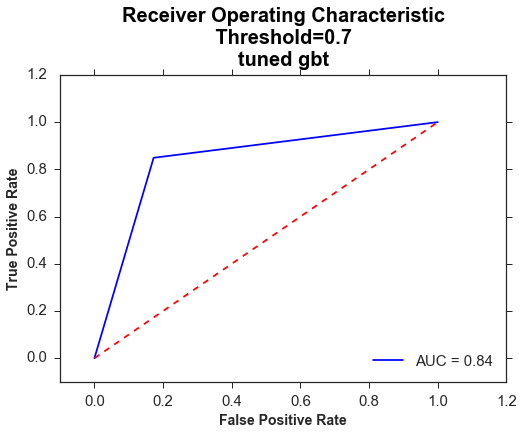

(0.8382436528988253, 0.36082474226804123)

In [24]:
ES.getAUC(Doc2Vec_tuned_gbt, test_data, predictors, y, threshold = 0.7, title_second_line="tuned gbt")